# A/B Testing

This note will approach A/B testing and the construction of confidence intervals from 3 perspectives:
- Frequentist
- Bayesian
- Emprical (via bootstrapping)

## Set Up

### Import Packages

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Constants and Parameters

In [3]:
# plotting defaults
sns.set_theme()
sns.set(font_scale=1.2)

# test results
GROUP_A_TRIALS = 513
GROUP_A_SUCCESSES = 59

GROUP_B_TRIALS = 2432
GROUP_B_SUCCESSES = 364

# size of confidence interval
CONFIDENCE_LEVEL = 95

## Bootstrapping

Improvement rate point estimate

In [4]:
group_a_success_rate = GROUP_A_SUCCESSES / GROUP_A_TRIALS
group_b_success_rate = GROUP_B_SUCCESSES / GROUP_B_TRIALS

improvement_rate = group_b_success_rate / group_a_success_rate - 1

Simulate data

*To do: replace simulated data with sampling from binomial distribution*

In [5]:
def simulate_binomial_data(n_trials, n_successes):
    n_failures = n_trials - n_successes
    simulated_data = np.concatenate([
        np.ones(n_successes), np.zeros(n_failures)
    ])
    
    return simulated_data


group_a_data = simulate_binomial_data(n_trials = GROUP_A_TRIALS, n_successes = GROUP_A_SUCCESSES)
group_b_data = simulate_binomial_data(n_trials = GROUP_B_TRIALS, n_successes = GROUP_B_SUCCESSES)

Perform the bootstrap resampling: in each iteration we simulate sampling from each distribution (the same number as in the A/B test), calculate the success rate for each, and then calculate the improvement rate. We end up with an array of `n_boostraps` improvement rates.

In [6]:
n_bootstraps = 10000

# simulate resamples from distribution
group_a_resamples = np.random.choice(group_a_data, size=(GROUP_A_TRIALS, n_bootstraps), replace=True)
group_a_bootstrap_success_rates = group_a_resamples.mean(axis=0)

group_b_resamples = np.random.choice(group_b_data, size=(GROUP_B_TRIALS, n_bootstraps), replace=True)
group_b_bootstrap_success_rates = group_b_resamples.mean(axis=0)

# calculate change in success rate
bootstrap_improvement_rates = group_b_bootstrap_success_rates / group_a_bootstrap_success_rates - 1

Generate a basic bootstrap confidence interval using the point estimate from the test (see https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Methods_for_bootstrap_confidence_intervals).

In [7]:
def generate_basic_bootstrap_interval(bootstrap_values, point_estimate, confidence_level = CONFIDENCE_LEVEL):
    percentiles = np.percentile(
        bootstrap_values, [50 - confidence_level / 2, 50 + confidence_level / 2]
    )
    interval = 2 * point_estimate - percentiles

    return np.sort(interval)

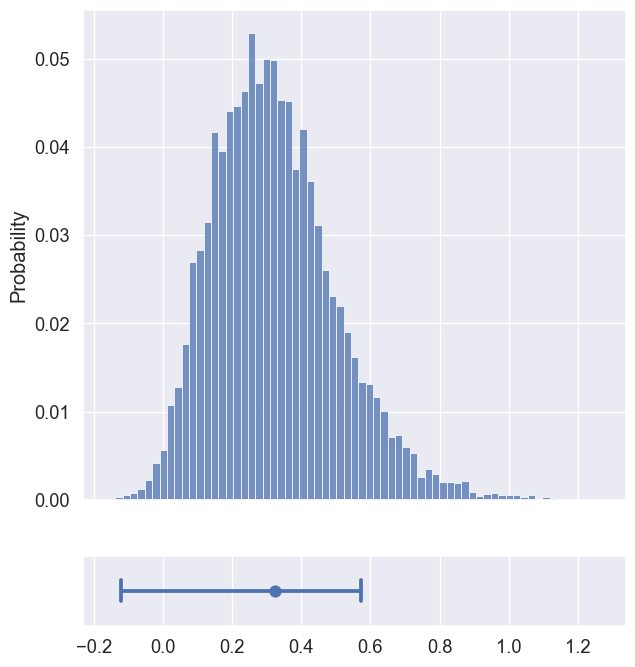

In [8]:
# figure
f, axs = plt.subplots(
    2, figsize=(7, 8), gridspec_kw={"height_ratios": [7, 1]}, sharex=True
)

# histogram of bootstrap values
sns.histplot(data=bootstrap_improvement_rates, stat="probability", ax=axs[0])

# confidence interval around point estimate
sns.pointplot(
    x=bootstrap_improvement_rates,
    errorbar=lambda x: generate_basic_bootstrap_interval(x, point_estimate=improvement_rate),
    capsize=0.3,
    ax=axs[1]
);

Print outcome

In [9]:
improvement_rate_confidence_interval = generate_basic_bootstrap_interval(bootstrap_values = bootstrap_improvement_rates, point_estimate = improvement_rate)

print("Point Estimate: {:.1f}%".format(100 * improvement_rate))
print("{}% Confidence Interval: [{:.1f}%, {:.1f}%]".format(CONFIDENCE_LEVEL, 100 * improvement_rate_confidence_interval[0], 100 * improvement_rate_confidence_interval[1]))

Point Estimate: 30.1%
95% Confidence Interval: [-12.2%, 57.3%]
